## VAEs- Deep Unsupervised Learning Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from IPython.display import clear_output
import time

In [2]:
# Choose device

device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets

train_set = datasets.FashionMNIST('Data_FashionMNIST/', download=True, train=True, transform=transform)
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.FashionMNIST('DATA_FashionMNIST/', download=True, train=False, transform=transform)
testLoader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

cuda


In [4]:
class ConvAutoEncoder(nn.Module):
    def __init__(self, num_hidden=8):
        super().__init__()
        
        # Set the number of hidden units
        self.num_hidden = num_hidden
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64*7*7, num_hidden)
        )
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(num_hidden, 32*7*7),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Pass the encoded representation through the decoder
        decoded = self.decoder(encoded)
        # Return both the encoded representation and the reconstructed output
        return encoded, decoded



In [5]:
class ConvVAE(ConvAutoEncoder):
    def __init__(self, num_hidden=8):
        super().__init__(num_hidden=num_hidden)
        # Add mu and log_var layers for reparameterization
        self.encoded_size = num_hidden
        self.mu = nn.Linear(self.encoded_size, self.num_hidden)
        self.log_var = nn.Linear(self.encoded_size, self.num_hidden)

    def reparameterize(self, mu, log_var):
        # Compute the standard deviation from the log variance
        std = torch.exp(0.5 * log_var)
        # Generate random noise using the same shape as std
        eps = torch.randn_like(std)
        # Return the reparameterized sample
        return mu + eps * std
    
    def sample(self, num_samples):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.num_hidden).to(device)
            
            # Pass the noise through the decoder to generate samples
            print(z.shape)
            samples = self.decoder(z)  # Reshape z to match decoder input size
        # Return the generated samples
        return samples
    
    def forward(self, x):
        # Pass the input through the encoder
        encoded = self.encoder(x)
        # Flatten the encoded representation
        encoded_flat = torch.flatten(encoded, start_dim=1)
        # Compute the mean and log variance vectors
        mu = self.mu(encoded_flat)
        log_var = self.log_var(encoded_flat)
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)
        # Pass the latent variable through the decoder
        decoded = self.decoder(z)  # Reshape z to match decoder input size
        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var


In [6]:
# Define a loss function that combines MSE and Kullback-Leibler divergence
def vae_loss_function(recon_x, x, mu, logvar, lamb=3):
    # Compute the MSE loss between the reconstructed output and the input data
    MSE = F.mse_loss(recon_x, x, reduction="sum")

    # Compute the Kullback-Leibler divergence between the learned latent variable distribution and a standard Gaussian distribution
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combine the two losses by adding them together and return the result
    return MSE + lamb * KLD

In [7]:
def train_vae(model, batch_size=64, learning_rate=1e-3, num_epochs=15):

    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Set the device to GPU if available, otherwise use CPU
    model.to(device)

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, (data,_) in enumerate(trainLoader):
            # Get a batch of training data and move it to the device           
            data = data.to(device)
            
            # Forward pass
            encoded, decoded, mu, log_var = model(data)

            # Compute the loss and perform backpropagation
            loss = vae_loss_function(decoded, data, mu, log_var, lamb=3)/len(data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the running loss
            total_loss += loss.item() * data.size(0)

        # Print the epoch loss
        epoch_loss = total_loss / len(trainLoader.dataset)
        print(
            "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
        )

In [8]:
model = ConvVAE(num_hidden=8)
train_vae(model)

/home/daniel/anaconda3/envs/deep/lib/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/15: loss=143.0384
Epoch 2/15: loss=102.9172
Epoch 3/15: loss=97.6774
Epoch 4/15: loss=95.0598
Epoch 5/15: loss=93.4200
Epoch 6/15: loss=92.3262
Epoch 7/15: loss=91.4752
Epoch 8/15: loss=90.8152
Epoch 9/15: loss=90.2464
Epoch 10/15: loss=89.8809
Epoch 11/15: loss=89.4483
Epoch 12/15: loss=89.1550
Epoch 13/15: loss=88.9910
Epoch 14/15: loss=88.7287
Epoch 15/15: loss=88.4649


torch.Size([1, 8])


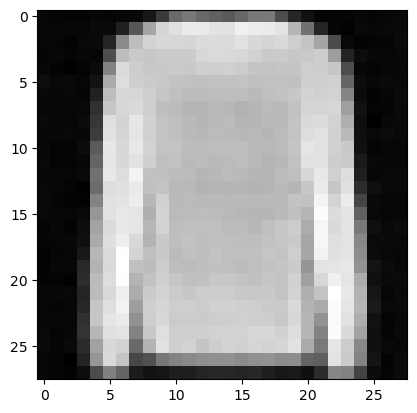

In [9]:
model.eval()

decoded = model.sample(1).squeeze().cpu().numpy()

plt.imshow(decoded, cmap="gray")
plt.show()

torch.Size([1, 8])


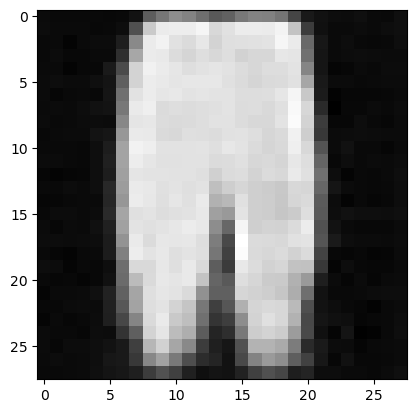

torch.Size([1, 8])


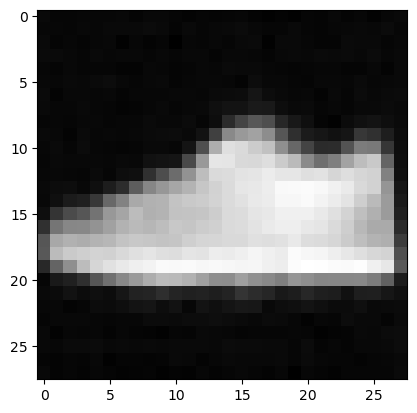

torch.Size([1, 8])


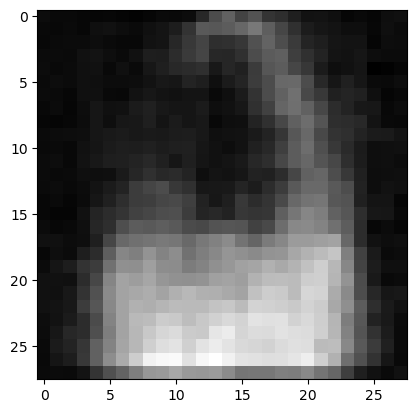

torch.Size([1, 8])


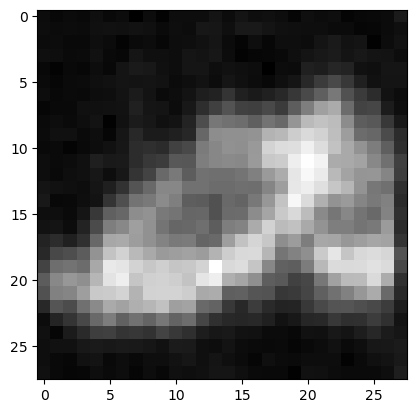

torch.Size([1, 8])


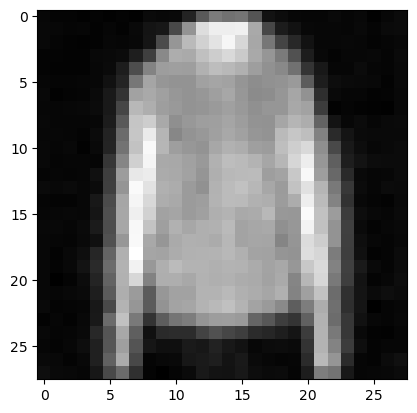

In [10]:
for i in range(5):
    model.eval()

    decoded = model.sample(1).squeeze().cpu().numpy()


    plt.imshow(decoded, cmap="gray")
    plt.show()

Original images


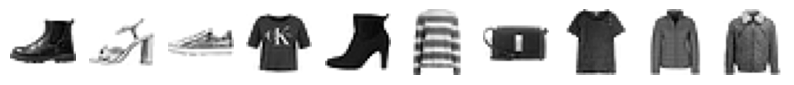

Reconstructed images


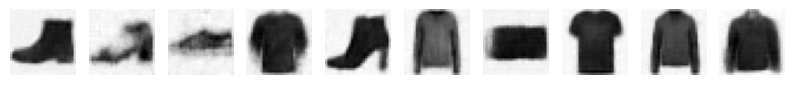

In [11]:
model
# Get a batch of test images
dataiter = iter(testLoader)
images, labels = next(dataiter)

# Show original images
plt.figure(figsize=(10, 4))
print('Original images')
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')
    plt.axis('off')
plt.show()

# Show reconstructed images
with torch.no_grad():
    model.eval()
    images = images.to(device)
    encoded, outputs, _, _ = model(images)
    outputs = outputs.view(-1, 1, 28, 28).cpu()
    plt.figure(figsize=(10, 4))
    print('Reconstructed images')
    for i in range(10):
        plt.subplot(2, 10, i + 1)
        plt.imshow(outputs[i].numpy().squeeze(), cmap='gray_r')
        plt.axis('off')
    plt.show()

samplin from AE with 8 latent dim
Original images


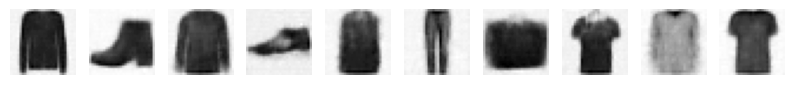

In [14]:
def sample_ae(model, num_samples=5):
  print(f"samplin from AE with {model.num_hidden} latent dim")
  model.eval()
  with torch.no_grad():
    latent = torch.randn(num_samples, model.num_hidden, device=device)
    decoded = model.decoder(latent)
    return decoded.view(-1, 28, 28).squeeze().cpu().numpy()
  
samples = 10
decoded = sample_ae(model, num_samples=samples)

plt.figure(figsize=(10, 4))
print('Original images')
for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(decoded[i], cmap='gray_r')
    plt.axis('off')
plt.show()